In [1]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cloudpickle as pickle
### Pytorch
import torch
import torch.nn as nn
from fastai.tabular import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, average_precision_score, f1_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
GLOBAL_SEED = 20210117
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(GLOBAL_SEED) 

# 1. Import data

In [3]:
[data_raw, protein_raw, activities_raw, 
 data_extend, protein_extend, activities_extend] = pickle.load(open('NR.pkl', 'rb'))
#mean, std = data_raw.mean(), data_raw.std() 

In [4]:
cont_names = data_raw.columns
cat_names = []
dep_var = 'Activity'
data_raw['Activity'] = [int(i<1) for i in activities_raw]
data_extend['Activity'] = [int(i<1) for i in activities_extend]
data_raw.shape, data_extend.shape
list(data_raw['Activity']).count(0), list(data_raw['Activity']).count(1)

((6554, 218), (713, 218))

(3129, 3425)

# 2. Create descriptor sets (only protein / only ligand / protein+ligand)

In [5]:
def oversampling(data, N=3000, sigma=0.1, test_size=0.4):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    protein_train = np.array([i.split('_')[0] for i in data.index])
    for train_idx, valid_idx in sss.split(data, protein_train):pass
    # sampling
    sample_data = []
    sample_label = []
    sample_proteins = []
    train_temp = data.iloc[train_idx, :]
    proteins = np.array([i.split('_')[0] for i in train_temp.index])
    for p in set(proteins):
        temp = train_temp.loc[proteins==p, :]
        if N-sum(proteins==p)<=0:
            continue
        for _ in range(N-sum(proteins==p)):
            rrow = list(temp.iloc[random.choice(range(len(temp.index))), :])
            sample_data.append(rrow)
            sample_label.append(int(rrow[-1]))
            sample_proteins.append(p)
    if len(sample_label) == 0:
        return data, train_idx, valid_idx
    sample_data = pd.DataFrame(norm.rvs(np.array(sample_data), scale=sigma), columns=data.columns)
    sample_data.index = [sample_proteins[i]+'_OS_'+str(i) for i in range(len(sample_proteins))]
    sample_data[dep_var] = sample_label
    os_data = pd.DataFrame(data)
    os_data = os_data.append(sample_data)
    os_train_idx = list(set(range(len(os_data.index)))-set(valid_idx))
    return os_data, os_train_idx, valid_idx

In [6]:
N, train_size, test_aucs, extend_aucs, result = pickle.load(open('NR_surface_DL_layer5_cell300_ps0.5.pkl', 'rb'))
result.sort_values('Extend AUC', ascending=False).head(2)

,N,Train size,Test AUC,Extend AUC
56,4000,0.8,0.890084,0.691880
74,5000,0.8,0.891106,0.680653


In [7]:
N = 4000
tr = 0.80
layern=5; celln=300; ps=0.5

os_data, train_idx, valid_idx = oversampling(data_raw, N, sigma=0.1, test_size=1-tr)
train_data = os_data.iloc[train_idx, :]
valid_data = os_data.iloc[valid_idx, :]

In [8]:
Protein_Desciptors = [i for i in data_raw.columns[:-1] if 'NR' in i]
Chemical_Desciptors = [i for i in data_raw.columns[:-1] if 'NR' not in i]

valid_data_no_protein = valid_data.copy()
valid_data_no_protein.loc[:, Protein_Desciptors] = 0.0

data_extend_no_protein = data_extend.copy()
data_extend_no_protein.loc[:, Protein_Desciptors] = 0.0

valid_data_no_chemical = valid_data.copy()
valid_data_no_chemical.loc[:, Chemical_Desciptors] = 0.0

data_extend_no_chemical = data_extend.copy()
data_extend_no_chemical.loc[:, Chemical_Desciptors] = 0.0

In [9]:
all_test = valid_data.copy()
all_test.index = ['Raw_Test_'+str(i) for i in range(valid_data.shape[0])]
###
temp = valid_data_no_protein.copy()
temp.index = ['Test_no_protein_'+str(i) for i in range(temp.shape[0])]
all_test = pd.concat([all_test, temp], axis=0, sort=False)
###
temp = valid_data_no_chemical.copy()
temp.index = ['Test_no_chemical_'+str(i) for i in range(temp.shape[0])]
all_test = pd.concat([all_test, temp], axis=0, sort=False)
#########
temp = data_extend.copy()
temp.index = ['Raw_Extend_'+str(i) for i in range(temp.shape[0])]
all_test = pd.concat([all_test, temp], axis=0, sort=False)
###
temp = data_extend_no_protein.copy()
temp.index = ['Extend_no_protein_'+str(i) for i in range(temp.shape[0])]
all_test = pd.concat([all_test, temp], axis=0, sort=False)
###
temp = data_extend_no_chemical.copy()
temp.index = ['Extend_no_chemical_'+str(i) for i in range(temp.shape[0])]
all_test = pd.concat([all_test, temp], axis=0, sort=False)

# 3. Predition

In [10]:
procs = []
data_tabular = (TabularList.from_df(os_data, cat_names=[], cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx=valid_idx)
                .label_from_df(cols=dep_var)
                .add_test(TabularList.from_df(all_test, cat_names=[], cont_names=cont_names, procs=procs))
                .databunch())
learn = tabular_learner(data_tabular, layers=[celln for i in range(layern)], metrics=accuracy, ps=ps, silent=False)
_ = learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,0.717586,0.691943,0.557590,00:15
1,0.665288,0.652339,0.586575,00:12
2,0.623548,0.619883,0.623188,00:12
3,0.583385,0.593941,0.655225,00:12
4,0.540680,0.533216,0.739893,00:14
5,0.489972,0.516850,0.740656,00:16
6,0.478658,0.507028,0.758963,00:14
7,0.472521,0.490089,0.773455,00:19
8,0.451669,0.467305,0.791762,00:15
9,0.424080,0.468680,0.784134,00:14


In [11]:
### Evaluate Extend
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
_, pred = preds.max(1)
pre_prob = preds[:, 1]
pred = 1-pred
pre_prob = 1-pre_prob

# 4. Evaluating

In [12]:
### Evaluate Test
index = [i for i in range(all_test.shape[0]) if 'Raw_Test' in all_test.index[i]]
fpr1, tpr1, thresholds1 = roc_curve(1-np.array(all_test[dep_var][index]), pre_prob[index])
test_auc = roc_auc_score(1-all_test[dep_var][index], pre_prob[index])
acc = accuracy_score(1-all_test[dep_var][index], pred[index])
precision = precision_score(1-all_test[dep_var][index], pred[index])
recall = recall_score(1-all_test[dep_var][index], pred[index])
f1 = f1_score(1-all_test[dep_var][index], pred[index])
np.round([acc, precision, recall, f1, test_auc], 3)

index = [i for i in range(all_test.shape[0]) if 'Test_no_protein' in all_test.index[i]]
fpr1_l, tpr1_l, thresholds1_l = roc_curve(1-np.array(all_test[dep_var][index]), pre_prob[index])
test_auc_l = roc_auc_score(1-all_test[dep_var][index], pre_prob[index])
acc = accuracy_score(1-all_test[dep_var][index], pred[index])
precision = precision_score(1-all_test[dep_var][index], pred[index])
recall = recall_score(1-all_test[dep_var][index], pred[index])
f1 = f1_score(1-all_test[dep_var][index], pred[index])
np.round([acc, precision, recall, f1, test_auc_l], 3)

index = [i for i in range(all_test.shape[0]) if 'Test_no_chemical' in all_test.index[i]]
fpr1_p, tpr1_p, thresholds1_p = roc_curve(np.array(1-all_test[dep_var][index]), pre_prob[index])
test_auc_p = roc_auc_score(1-all_test[dep_var][index], pre_prob[index])
acc = accuracy_score(1-all_test[dep_var][index], pred[index])
precision = precision_score(1-all_test[dep_var][index], pred[index])
recall = recall_score(1-all_test[dep_var][index], pred[index])
f1 = f1_score(1-all_test[dep_var][index], pred[index])
np.round([acc, precision, recall, f1, test_auc_p], 3)

### Evaluate Extend
index = [i for i in range(all_test.shape[0]) if 'Raw_Extend' in all_test.index[i]]
fpr2, tpr2, thresholds2 = roc_curve(1-np.array(all_test[dep_var][index]), pre_prob[index])
extend_auc = roc_auc_score(1-all_test[dep_var][index], pre_prob[index])
acc = accuracy_score(1-all_test[dep_var][index], pred[index])
precision = precision_score(1-all_test[dep_var][index], pred[index])
recall = recall_score(1-all_test[dep_var][index], pred[index])
f1 = f1_score(1-all_test[dep_var][index], pred[index])
np.round([acc, precision, recall, f1, extend_auc], 3)

index = [i for i in range(all_test.shape[0]) if 'Extend_no_protein' in all_test.index[i]]
fpr2_l, tpr2_l, thresholds2_l = roc_curve(1-np.array(all_test[dep_var][index]), pre_prob[index])
extend_auc_l = roc_auc_score(1-all_test[dep_var][index], pre_prob[index])
acc = accuracy_score(1-all_test[dep_var][index], pred[index])
precision = precision_score(1-all_test[dep_var][index], pred[index])
recall = recall_score(1-all_test[dep_var][index], pred[index])
f1 = f1_score(1-all_test[dep_var][index], pred[index])
np.round([acc, precision, recall, f1, extend_auc_l], 3)

index = [i for i in range(all_test.shape[0]) if 'Extend_no_chemical' in all_test.index[i]]
fpr2_p, tpr2_p, thresholds2_p = roc_curve(1-np.array(all_test[dep_var][index]), pre_prob[index])
extend_auc_p = roc_auc_score(1-all_test[dep_var][index], pre_prob[index])
acc = accuracy_score(1-all_test[dep_var][index], pred[index])
precision = precision_score(1-all_test[dep_var][index], pred[index])
recall = recall_score(1-all_test[dep_var][index], pred[index])
f1 = f1_score(1-all_test[dep_var][index], pred[index])
np.round([acc, precision, recall, f1, extend_auc_p], 3)

array([0.815, 0.777, 0.9  , 0.834, 0.893])

array([0.506, 0.536, 0.339, 0.416, 0.547])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.483, 0.   , 0.   , 0.   , 0.518])

array([0.668, 0.714, 0.745, 0.729, 0.675])

array([0.408, 0.6  , 0.042, 0.079, 0.513])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.4  , 0.   , 0.   , 0.   , 0.534])

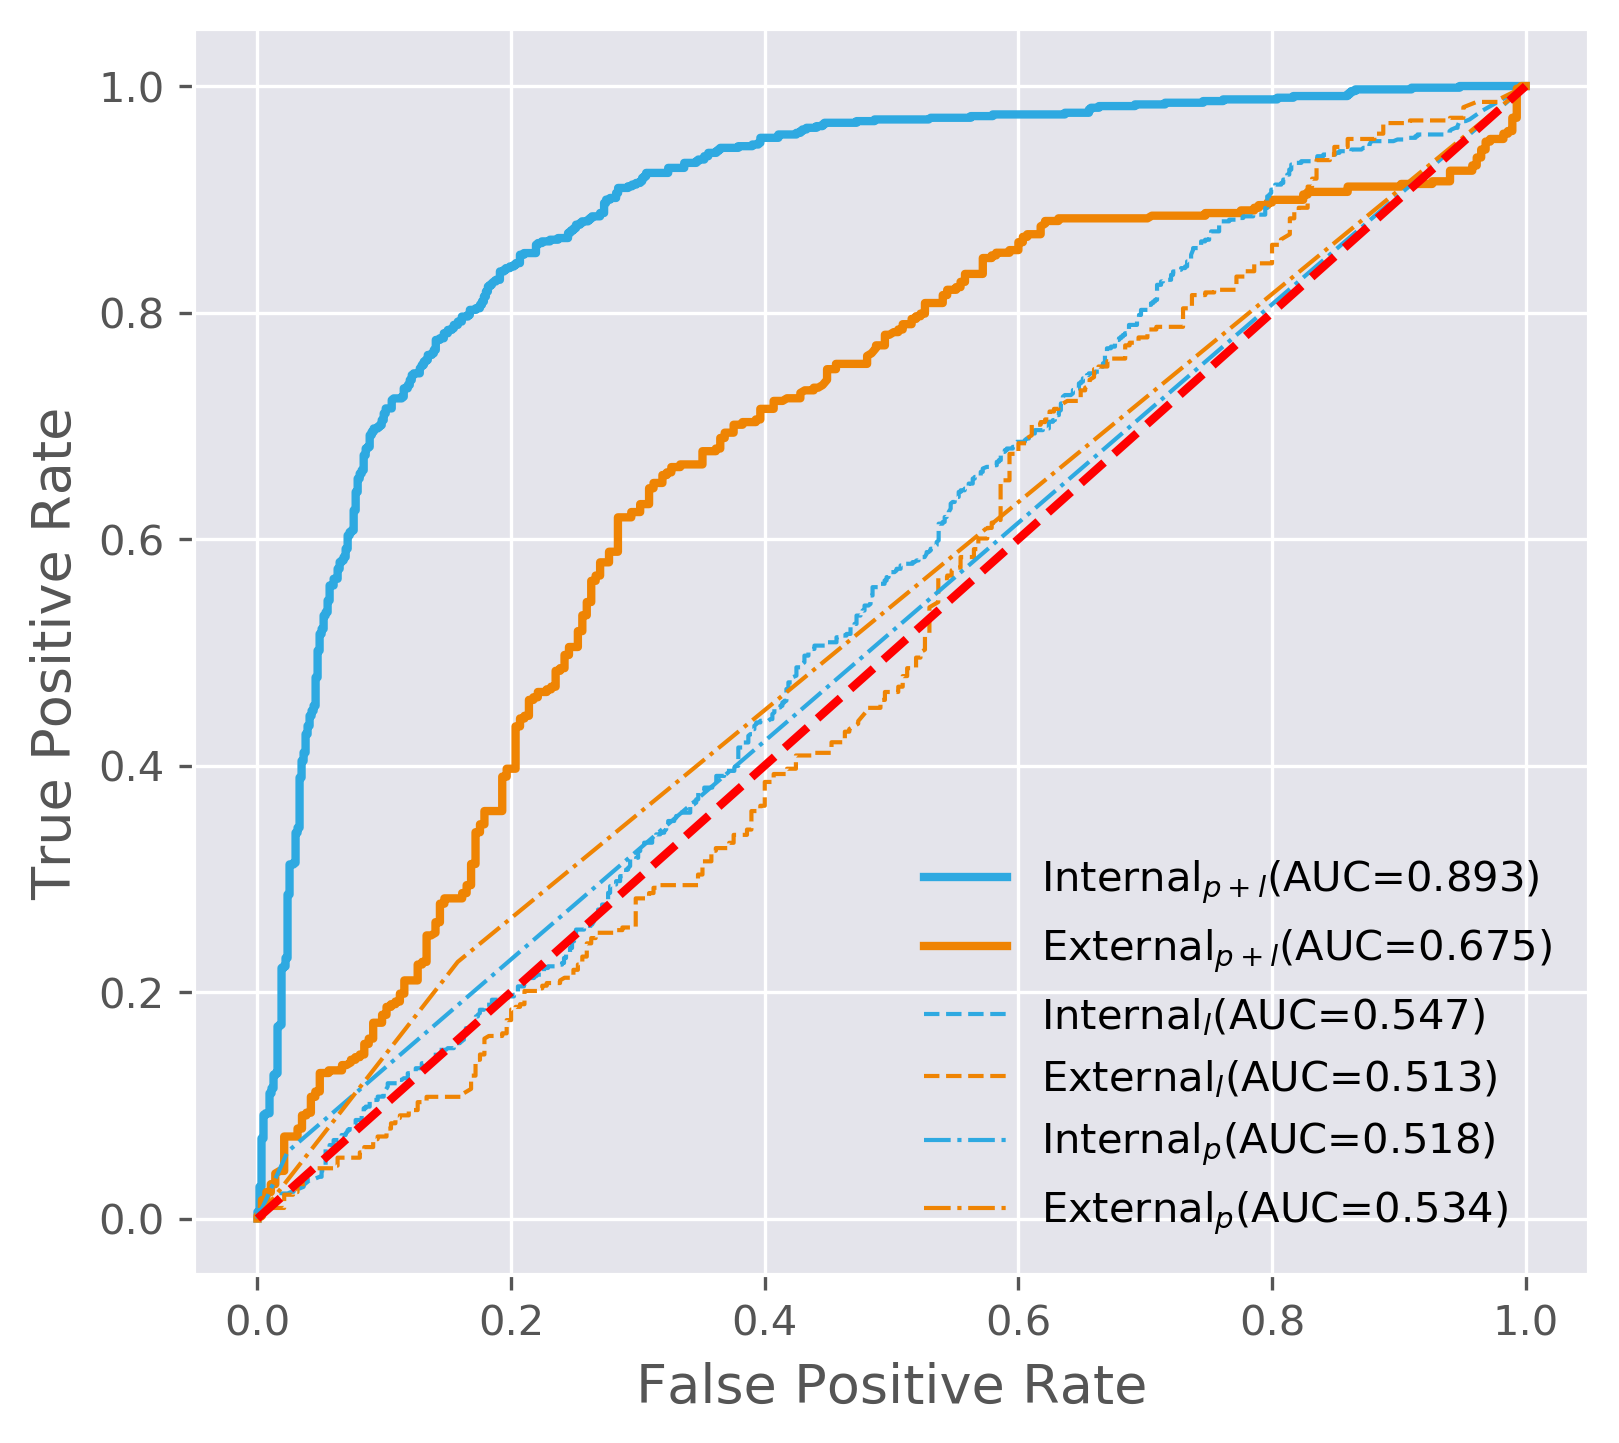

In [13]:
_ = plt.style.use('ggplot')
_ = plt.figure(1, (6, 5.5), dpi=300)
ax = plt.gca(); ax.set_facecolor('#e4e4eb')

_ = plt.plot(fpr1, tpr1, 'b-', lw=2, color='#2ca9e1', alpha=0.99, 
             label='Internal$_{{{}}}$(AUC={})'.format('p+l', round(test_auc, 3)))
_ = plt.plot(fpr2, tpr2, 'r-', lw=2, color='#f08300', alpha=0.99, 
             label='External$_{{{}}}$(AUC={})'.format('p+l', round(extend_auc, 3)))

_ = plt.plot(fpr1_l, tpr1_l, 'b--', lw=1, color='#2ca9e1', alpha=0.99, 
             label='Internal$_{{{}}}$(AUC={})'.format('l', round(test_auc_l, 3)))
_ = plt.plot(fpr2_l, tpr2_l, 'r--', lw=1, color='#f08300', alpha=0.99, 
             label='External$_{{{}}}$(AUC={})'.format('l', round(extend_auc_l, 3)))


_ = plt.plot(fpr1_p, tpr1_p, 'b-.', lw=1, color='#2ca9e1', alpha=0.99,
             label='Internal$_{{{}}}$(AUC={})'.format('p', round(test_auc_p, 3)))
_ = plt.plot(fpr2_p, tpr2_p, 'r-.', lw=1, color='#f08300', alpha=0.99, 
             label='External$_{{{}}}$(AUC={})'.format('p', round(extend_auc_p, 3)))
_ = plt.plot([0, 1], [0, 1], ls='--', lw=2, color='r')
_ = plt.legend(loc='lower right', fontsize=10, frameon=False)
_ = plt.xlim([-0.05, 1.05])
_ = plt.ylim([-0.05, 1.05])
_ = plt.xlabel('False Positive Rate', fontsize=13)
_ = plt.ylabel('True Positive Rate', fontsize=13)
_ = plt.show()